<a href="https://colab.research.google.com/github/javohir-ergashboyev/tensorflow_basics/blob/main/Overfitting_and_Underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers

In [5]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ljj7kdcw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ljj7kdcw
  Resolved https://github.com/tensorflow/docs to commit d13c500b2e552ce04095287a99c575d2685a2160
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.1.17.4828-py3-none-any.whl size=181243 sha256=c291cecda1ff2ce8cefd734a054ac7195f2ee9e0ee7256b630679797d4c367b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-raei4ei5/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [7]:
import tensorflow_docs as tfdocs
from tensorflow_docs import modeling
from tensorflow_docs import plots

In [8]:
from IPython import display
import matplotlib.pyplot as plt
import pathlib
import shutil
import tempfile

In [9]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [10]:
url='http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz'
gz=tf.keras.utils.get_file('HIGGS.csv.gz', url)

2816407858/2816407858 [==============================] - 1134s 0us/step


In [11]:
FEATURES=28
ds=tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type='GZIP')

In [12]:
def pack_row(*row):
  label=row[0]
  features=tf.stack(row[1:],1)
  return features, label

In [13]:
packed_ds=ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


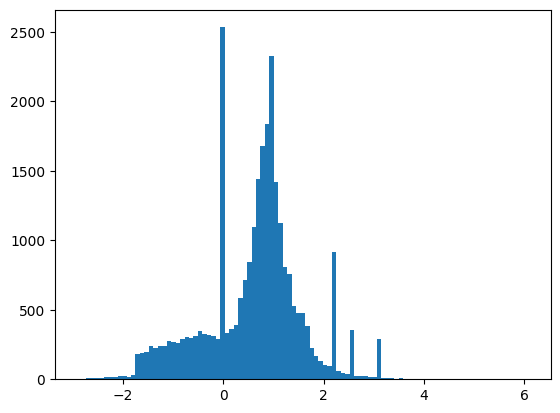

In [14]:
for features, labels in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [15]:
N_VALIDATION=int(1e3)
N_TRAIN=int(1e4)
BUFFER_SIZE=int(1e4)
BATCH_SIZE=500
STEPS_PER_EPOCHS=N_TRAIN//BATCH_SIZE

In [16]:
validate_ds=packed_ds.take(N_VALIDATION).cache()
train_ds=packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [17]:
validate_ds=validate_ds.batch(BATCH_SIZE)
train_ds=train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [18]:
lr_schedule=tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCHS*1000,
    decay_rate=1,
    staircase=False
)
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

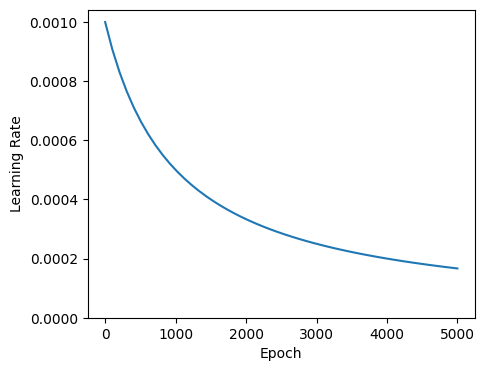

In [19]:
step=np.linspace(0,100000)
lr=lr_schedule(step)
plt.figure(figsize=(5,4))
plt.plot(step/STEPS_PER_EPOCHS, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')



In [20]:
def callbacks(name):
  return [
      modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name)
  ]

In [21]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
      optimizer=get_optimizer()
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[
          tf.keras.losses.BinaryCrossentropy(
              from_logits=True,
              name='binary_crossentropy'
              ),
          'accuracy'
      ])
  history=model.fit(
      train_ds,
      steps_per_epoch=STEPS_PER_EPOCHS,
      epochs=max_epochs,
      verbose=0,
      validation_data=validate_ds,
      callbacks=callbacks(name)
  )
  return history

**TINY model**

In [22]:
tiny_model=tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

In [23]:
size_histories={}

In [24]:
size_histories['Tiny']=compile_and_fit(tiny_model, 'sizes/Tiny')


Epoch: 0, accuracy:0.4920,  binary_crossentropy:0.7539,  loss:0.7539,  val_accuracy:0.5050,  val_binary_crossentropy:0.7361,  val_loss:0.7361,  
....................................................................................................
Epoch: 100, accuracy:0.6034,  binary_crossentropy:0.6217,  loss:0.6217,  val_accuracy:0.5800,  val_binary_crossentropy:0.6303,  val_loss:0.6303,  
....................................................................................................
Epoch: 200, accuracy:0.6392,  binary_crossentropy:0.6049,  loss:0.6049,  val_accuracy:0.6200,  val_binary_crossentropy:0.6101,  val_loss:0.6101,  
....................................................................................................
Epoch: 300, accuracy:0.6549,  binary_crossentropy:0.5952,  loss:0.5952,  val_accuracy:0.6380,  val_binary_crossentropy:0.5980,  val_loss:0.5980,  
....................................................................................................
Epoch: 40

**SMALL model**

In [25]:
small_model=tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small']=compile_and_fit(small_model, 'sizes/Small')


Epoch: 0, accuracy:0.4748,  binary_crossentropy:0.7972,  loss:0.7972,  val_accuracy:0.4690,  val_binary_crossentropy:0.7453,  val_loss:0.7453,  
....................................................................................................
Epoch: 100, accuracy:0.6192,  binary_crossentropy:0.6131,  loss:0.6131,  val_accuracy:0.5980,  val_binary_crossentropy:0.6216,  val_loss:0.6216,  
....................................................................................................
Epoch: 200, accuracy:0.6537,  binary_crossentropy:0.5907,  loss:0.5907,  val_accuracy:0.6680,  val_binary_crossentropy:0.5928,  val_loss:0.5928,  
....................................................................................................
Epoch: 300, accuracy:0.6696,  binary_crossentropy:0.5814,  loss:0.5814,  val_accuracy:0.6700,  val_binary_crossentropy:0.5890,  val_loss:0.5890,  
....................................................................................................
Epoch: 40

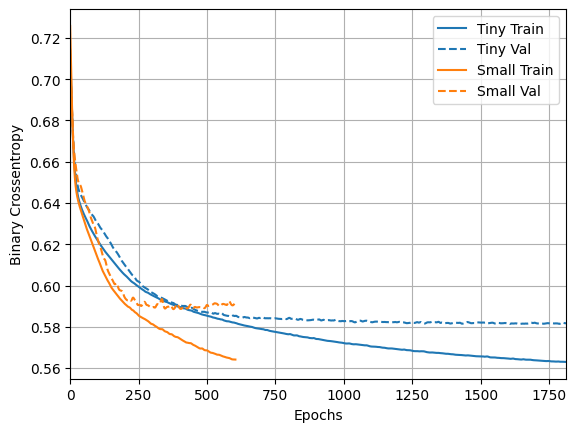

In [27]:
plotter=plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plotter.ylim=([0.5,0.7])

In [28]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [29]:
size_histories['Medium']=compile_and_fit(medium_model, 'sizes/Medium')


Epoch: 0, accuracy:0.4879,  binary_crossentropy:0.6995,  loss:0.6995,  val_accuracy:0.4640,  val_binary_crossentropy:0.6789,  val_loss:0.6789,  
....................................................................................................
Epoch: 100, accuracy:0.7206,  binary_crossentropy:0.5253,  loss:0.5253,  val_accuracy:0.6730,  val_binary_crossentropy:0.6011,  val_loss:0.6011,  
....................................................................................................
Epoch: 200, accuracy:0.7839,  binary_crossentropy:0.4337,  loss:0.4337,  val_accuracy:0.6390,  val_binary_crossentropy:0.6747,  val_loss:0.6747,  
.........................................................

In [30]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [31]:
size_histories['Large'] = compile_and_fit(large_model, "sizes/Large")


Epoch: 0, accuracy:0.5107,  binary_crossentropy:0.8401,  loss:0.8401,  val_accuracy:0.4680,  val_binary_crossentropy:0.7030,  val_loss:0.7030,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0027,  loss:0.0027,  val_accuracy:0.6560,  val_binary_crossentropy:1.7571,  val_loss:1.7571,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0002,  loss:0.0002,  val_accuracy:0.6590,  val_binary_crossentropy:2.4340,  val_loss:2.4340,  
......................

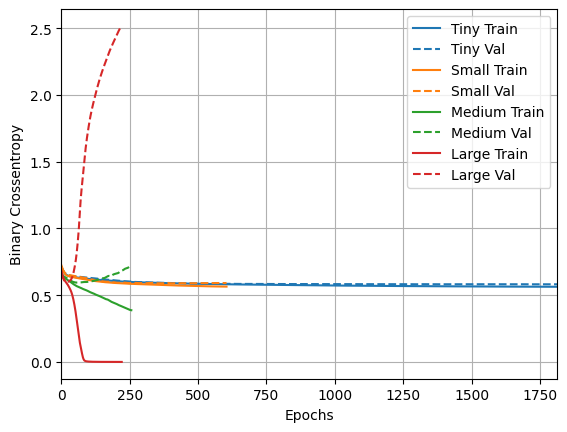

In [32]:
plotter.plot(size_histories)
plotter.ylim=([0.5,0.7])

**Regularize**

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp7gia3tjx/tensorboard_logs/regularizers/Tiny')

In [34]:
regularized_hist={}
regularized_hist['Tiny']=size_histories['Tiny']

In [35]:
regularized_model=tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.L2(0.001),input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dense(512, activation='elu',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dense(512, activation='elu',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dense(1)
])

In [36]:
regularized_hist['regularized'] = compile_and_fit(regularized_model, "regularizers/L2")


Epoch: 0, accuracy:0.5005,  binary_crossentropy:0.8544,  loss:2.3792,  val_accuracy:0.5750,  val_binary_crossentropy:0.6830,  val_loss:2.1419,  
....................................................................................................
Epoch: 100, accuracy:0.6578,  binary_crossentropy:0.5965,  loss:0.6194,  val_accuracy:0.6730,  val_binary_crossentropy:0.5887,  val_loss:0.6117,  
....................................................................................................
Epoch: 200, accuracy:0.6729,  binary_crossentropy:0.5832,  loss:0.6063,  val_accuracy:0.6180,  val_binary_crossentropy:0.5951,  val_loss:0.6183,  
....................................................................................................
Epoch: 300, accuracy:0.6776,  binary_crossentropy:0.5719,  loss:0.5959,  val_accuracy:0.6520,  val_binary_crossentropy:0.5839,  val_loss:0.6079,  
....................................................................................................
Epoch: 40

**Dropout**

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [38]:
regularized_hist['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")


Epoch: 0, accuracy:0.5033,  binary_crossentropy:0.8042,  loss:0.8042,  val_accuracy:0.5320,  val_binary_crossentropy:0.6772,  val_loss:0.6772,  
....................................................................................................
Epoch: 100, accuracy:0.6518,  binary_crossentropy:0.5966,  loss:0.5966,  val_accuracy:0.6910,  val_binary_crossentropy:0.5777,  val_loss:0.5777,  
....................................................................................................
Epoch: 200, accuracy:0.6863,  binary_crossentropy:0.5539,  loss:0.5539,  val_accuracy:0.6800,  val_binary_crossentropy:0.5884,  val_loss:0.5884,  
....................................................................................................
Epoch: 300, accuracy:0.7218,  binary_crossentropy:0.5087,  loss:0.5087,  val_accuracy:0.6820,  val_binary_crossentropy:0.5947,  val_loss:0.5947,  
.....................................................

**Combine Reguarization and Dropout**

In [39]:
combined_model=tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.L2(0.001),input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',kernel_regularizer=regularizers.L2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [40]:
regularized_hist['combined'] = compile_and_fit(combined_model, "regularizers/combined")


Epoch: 0, accuracy:0.5054,  binary_crossentropy:0.8033,  loss:2.3311,  val_accuracy:0.5350,  val_binary_crossentropy:0.6819,  val_loss:2.1432,  
....................................................................................................
Epoch: 100, accuracy:0.5684,  binary_crossentropy:0.6443,  loss:0.6563,  val_accuracy:0.5520,  val_binary_crossentropy:0.6353,  val_loss:0.6474,  
....................................................................................................
Epoch: 200, accuracy:0.5721,  binary_crossentropy:0.6432,  loss:0.6540,  val_accuracy:0.5490,  val_binary_crossentropy:0.6322,  val_loss:0.6429,  
....................................................................................................
Epoch: 300, accuracy:0.5725,  binary_crossentropy:0.6442,  loss:0.6557,  val_accuracy:0.5640,  val_binary_crossentropy:0.6300,  val_loss:0.6413,  
....................................................................................................
Epoch: 40

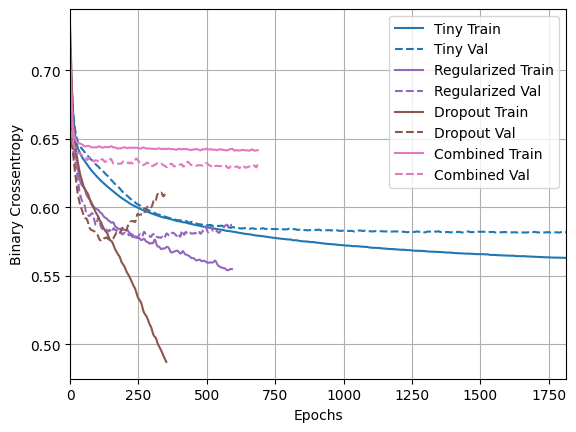

In [41]:
plotter.plot(regularized_hist)
plotter.ylim=([0.5,0.7])